In [1]:
import pandas as pd, numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df={}
df['tumor']=pd.read_pickle("model_patch_annotations/tumor_annot.pkl")
df['macro']=pd.read_pickle("model_patch_annotations/macro_annot.pkl")
df['tumor']['y_true']=LabelEncoder().fit_transform(df['tumor']['annotation'])
df['macro']['y_true']=LabelEncoder().fit_transform(df['macro']['annotation'])
df['macro'].loc[df['macro']['y_true']==4,'y_true']=-1

In [ ]:
for k in df:
    df[k]['case']=df[k]['ID'].map(lambda x: x.split("_")[0])

In [ ]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split


In [ ]:
counts={}
for k in df:
    counts[k]=pd.concat([dff['annotation'].value_counts() for name,dff in df[k].groupby("ID")],axis=1).T.fillna(0.)
    counts[k]['case']=np.vectorize(lambda x: x.split("_")[0])(df[k]['ID'].unique())
    counts[k].index=df[k]['ID'].unique()
    counts[k]=counts[k].groupby('case')[df[k]['annotation'].unique()].sum()
    if k=='macro': counts[k]=counts[k].drop(columns=['unassigned'])

In [ ]:
train_val_cases=dict()
for k in counts:
    np.random.seed(42)
    case_train, _, case_val, _ = iterative_train_test_split(counts[k].index.values.reshape(-1,1), (counts[k].apply(lambda x: x/x.sum(),axis=1)>counts[k].apply(lambda x: x/x.sum(),axis=1).median(0)).values, test_size = 0.2)
    train_val_cases[k]=dict(train=df[k].loc[df[k]['case'].isin(case_train.flatten())],val=df[k].loc[df[k]['case'].isin(case_val.flatten())])
    if k=="macro": 
        for k2 in train_val_cases[k]: train_val_cases[k][k2]=train_val_cases[k][k2].loc[train_val_cases[k][k2]['annotation']!='unassigned']
    

In [ ]:
import pickle
pickle.dump(train_val_cases,open('patches/train_val_patch_info.pkl','wb'))

In [ ]:
import pickle
train_val_cases=pickle.load(open('patches/train_val_patch_info.pkl','rb'))

In [ ]:
for k in train_val_cases:
    np.random.seed(42)
    train_val_cases[k]['train']=pd.concat([dff.sample(min(dff.shape[0],35000)) for name,dff in train_val_cases[k]['train'].groupby(['annotation'])])#ID
    np.random.seed(42)
    train_val_cases[k]['val']=pd.concat([dff.sample(min(dff.shape[0],7000)) for name,dff in train_val_cases[k]['val'].groupby(['annotation'])])#ID
#     for k2 in train_val_cases[k]:
#         np.random.seed(42)
#         train_val_cases[k][k2]=pd.concat([dff.sample(min(dff.shape[0],2500)) for _,dff in train_val_cases[k][k2].groupby(['ID'])])#train_val_cases[k][k2].sort_values("ID").reset_index(drop=True)

In [ ]:
# maybe increase this number
for k in train_val_cases:
    for k2 in train_val_cases[k]:
        print(train_val_cases[k][k2]['annotation'].value_counts())

In [ ]:
# can use above as train val cases for partitioning graph datasets

In [ ]:
import tqdm
# https://github.com/Lyken17/Efficient-PyTorch
for k in tqdm.tqdm(list(train_val_cases.keys()),desc="macro_tumor"):
    for k2 in tqdm.tqdm(list(train_val_cases[k].keys()),desc="train_val"):
        X,y=[],[]
        for name, dff in tqdm.tqdm(train_val_cases[k][k2].groupby('ID'),total=train_val_cases[k][k2]['ID'].nunique(),desc="case"):
            arr=np.load(f"inputs/{name}.npy")
            X.extend([arr[x:x+patch_size,y:y+patch_size] for x,y,patch_size in tqdm.tqdm(dff[['x','y','patch_size']].values.tolist(),desc='patch')])
            y.append(dff['y_true'].values.flatten())
            del arr
        X=np.stack(X)
        y=np.hstack(y)
        with open(f'patches/{k}/{k2}_data.pkl','wb') as f:
            pickle.dump(dict(X=X,y=y,patch_info=train_val_cases[k][k2]),f,pickle.HIGHEST_PROTOCOL)
        # FINISH; dump patches to pickle file; make 4 pickle files and get training up and running; maybe view few images

In [ ]:
# evaluate input data
! ls patches/*/*.pkl
! ls inputs

In [3]:
val_data=pd.read_pickle("patches/tumor/val_data.pkl")

In [5]:
df_anno=pd.read_pickle("model_patch_annotations/tumor_annot.pkl")
df_anno['ID'].unique()

array(['100_A1b', '163_A1c', '316_A1c', '97_A1b', '189_A1a', '117_A1b',
       '322_A2a', '329_A1b', '125_A2b', '9_A7b', '89_A1c', '146_A1c',
       '33_A1a', '302_A1a', '65_A1b', '293_A1', '48_A1b', '173_A1a',
       '28_A2a', '135_A1b', '317_A1a', '100_C1b', '326_A1b', '67_A1b',
       '297_A1b', '107_A1b', '153_A1d', '163_B2b', '163_A1b', '153_A1c',
       '104_A1a', '125_A2d', '105_A1b', '118_A1b', '48_A2c', '124_A1a',
       '322_B2a', '75_A1b', '322_B1a', '105_A1c', '51_A1a', '100_B1b',
       '291_A1c', '140_A1b', '48_A2d', '135_A1d', '178_A1a', '234_A1a',
       '15_A1a', '117_A1a', '95_A2a', '282_A1a', '163_A1a', '117_A1c',
       '26_A2b', '97_A1a', '140_A1c', '125_A2c', '120_B1b', '19_A1a',
       '287_A1a', '3_A2d', '307_A1', '212_A1b', '51_B1a', '264_A1',
       '182_A1a', '26_A1b', '151_A1c', '88_A2a', '67_A1a', '171_A1a',
       '75_A1a', '146_A1d', '86_A1a', '151_A1eX', '158_A1a', '107_A1c',
       '49_A1b', '95_A1b', '51_C1a', '326_A1a', '52_A1c', '105_A2c',
       '32

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Text(0.5, 1.0, '140_A1b')

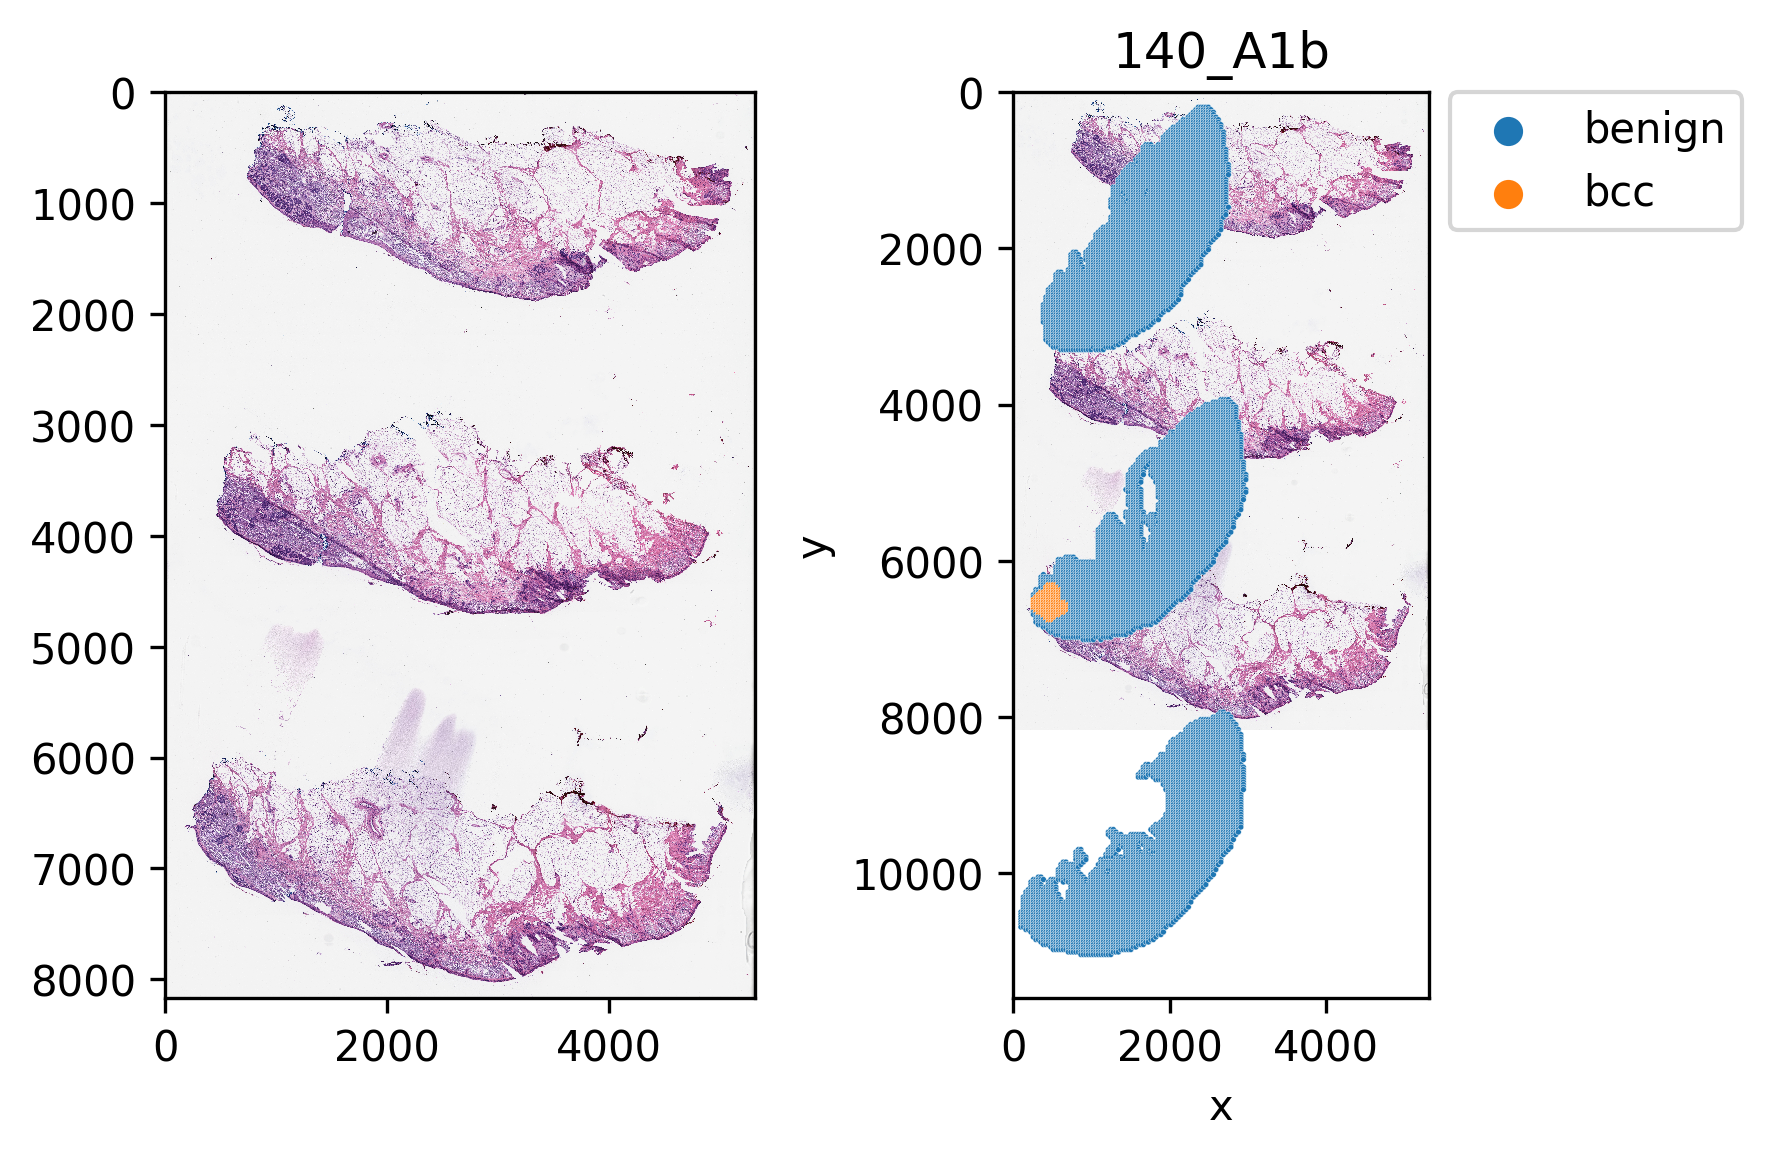

In [10]:
import cv2,tifffile
import seaborn as sns
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300

k="173_A1a"
arr=cv2.resize(tifffile.imread(f"new_test_slides/ASAP_Tiff/{k}_ASAP.tif"),None,fx=1/8,fy=1/8)#np.load(f"inputs/{k}.npy")

plt.subplot(121)
plt.imshow(np.transpose(arr,(1,0,2)))
plt.subplot(122)
plt.imshow(np.transpose(arr,(1,0,2)))
# for name,dff in val_data['patch_info'].groupby('ID'):#
dff=df_anno[df_anno['ID']==k]
# plt.figure()
dff[['x','y']]=dff[['y','x']].iloc[:,::-1]/8
sns.scatterplot(x='x',y='y',hue='annotation',data=dff,s=2.,alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(k)

In [ ]:
# break

In [ ]:
annots=np.hstack([annot for _,annot in val_data['patch_info'].groupby('ID')['annotation']])

In [ ]:
np.unique(annots)

In [ ]:
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300
from skimage.io import imshow_collection
k='benign'
idx=np.where(annots==k)[0]
np.random.shuffle(idx)
fig=imshow_collection(val_data['X'][idx[:12]])
plt.suptitle(k)


In [ ]:
# evaluate output data

In [ ]:
val_data['patch_info']['ID'].unique()


In [17]:
import torch
from sklearn.metrics import classification_report, roc_auc_score

In [18]:
k,k2='train','tumor'
preds=torch.load(f'pred_{k}_{k2}_tmp.pkl')
val_data=pd.read_pickle(f"patches/{k2}/{k}_data.pkl")
annots=np.hstack([annot for _,annot in val_data['patch_info'].groupby('ID')['annotation']])
IDs=np.hstack([[name]*len(annot) for name,annot in val_data['patch_info'].groupby('ID')['annotation']])
lbl2annot=dict(zip(preds['true'],annots))

In [19]:
result_arr=pd.DataFrame(np.hstack([np.vstack([IDs,preds['true']]).T,preds['pred']]),columns=["ID","True"]+list(lbl2annot.values()))

In [20]:
from scipy.special import softmax#softmax(x.iloc[:,-3:].values.astype(float),1))#
pd.set_option('display.max_rows', len(IDs)+1)

pd.DataFrame(result_arr.groupby("ID").apply(lambda x:np.min([roc_auc_score(x['True'].values.astype(int)==i,softmax(x.iloc[:,-3:].values.astype(float),1)[:,i]) for i in range(3) if sum(x['True'].values.astype(int)==i)]) if x['True'].nunique()>=2 else -1))

,0
ID,
102_A1b,0.875883
102_A1d,0.871808
104_A1a,0.884612
107_A1b,0.893640
107_A1c,0.883350
117_A1a,0.901578
117_A1b,0.894286
117_A1c,0.899522
118_A1b,0.878377


In [34]:
from sklearn.metrics import f1_score
pd.DataFrame(result_arr.groupby("ID").apply(lambda x:np.min([f1_score(x['True'].values.astype(int)==i,x.iloc[:,-3:].values.astype(float).argmax(1)==i) for i in range(3) if sum(x['True'].values.astype(int)==i)]) ) ).sort_values(by=[0])

,0
ID,
49_A1b,0.614108
125_A2b,0.620209
95_A1b,0.639566
26_A1b,0.645833
48_A2d,0.648485
88_A1a,0.650000
3_A2d,0.652542
75_A1b,0.653673
118_A1b,0.655172


In [9]:
lbl2annot

{1: 'benign', 2: 'benign', 0: 'benign'}

In [7]:
print(classification_report(pd.Series(preds['true']).map(lbl2annot),pd.Series(preds['pred'].argmax(1)).map(lbl2annot)))
print("AUC",[roc_auc_score(preds['true']==i,preds['pred'][:,i]) for i in range(preds['pred'].shape[1])])
pd.crosstab(pd.Series(preds['true'],name='true').map(lbl2annot),pd.Series(preds['pred'].argmax(1),name='pred').map(lbl2annot))

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     96596

    accuracy                           1.00     96596
   macro avg       1.00      1.00      1.00     96596
weighted avg       1.00      1.00      1.00     96596

AUC [0.8973682866698208, 0.8883422205059699, 0.8748502516490126]


pred,benign
true,
benign,96596


In [35]:
import torch
k,k2='train','macro'
preds=torch.load(f'pred_{k}_{k2}_tmp.pkl')
val_data=pd.read_pickle(f"patches/{k2}/{k}_data.pkl")

In [36]:
annots=np.hstack([annot for _,annot in val_data['patch_info'].groupby('ID')['annotation']])
IDs=np.hstack([[name]*len(annot) for name,annot in val_data['patch_info'].groupby('ID')['annotation']])

lbl2annot=dict(zip(preds['true'],annots))

In [37]:
print(classification_report(pd.Series(preds['true']).map(lbl2annot),pd.Series(preds['pred'].argmax(1)).map(lbl2annot)))
print("AUC",[roc_auc_score(preds['true']==i,preds['pred'][:,i]) for i in range(preds['pred'].shape[1])])
pd.crosstab(pd.Series(preds['true'],name='true').map(lbl2annot),pd.Series(preds['pred'].argmax(1),name='pred').map(lbl2annot))

                     precision    recall  f1-score   support

subcutaneous tissue       1.00      1.00      1.00    102208

           accuracy                           1.00    102208
          macro avg       1.00      1.00      1.00    102208
       weighted avg       1.00      1.00      1.00    102208

AUC [0.903647671195606, 0.9426177883508419, 0.7832902551527006, 0.8564306224173993]


pred,subcutaneous tissue
true,
subcutaneous tissue,102208


In [42]:
from scipy.special import softmax#softmax(x.iloc[:,-3:].values.astype(float),1))#
result_arr=pd.DataFrame(np.hstack([np.vstack([IDs,preds['true']]).T,preds['pred']]),columns=["ID","True"]+list(lbl2annot.values()))
result_arr.groupby("ID").apply(lambda x:np.min([roc_auc_score(x['True'].values.astype(int)==i,softmax(x.iloc[:,-4:].values.astype(float),1)[:,i]) for i in range(4) if sum(x['True'].values.astype(int)==i)]) if x['True'].nunique()>=2 else -1)

ID
108_A1c    0.965679
108_A1d    0.944006
153_A1d    0.946414
15_A1a     0.949897
20_B1c     0.950610
20_B1d     0.948377
37_A1c     0.949674
37_A2d     0.946554
37_A2eX    0.949301
3_A2b      0.944437
3_A2c      0.953239
41_A2b     0.951584
44_A1c     0.952821
46_A2b     0.956380
47_A1c     0.952488
53_A1b     0.947484
5_A1d      0.940966
5_A1eX     0.952390
60_A1c     0.966336
60_A1d     0.946073
66_A1b     0.948748
78_A2d     0.948094
90_A2b     0.958239
91_A2b     0.950303
dtype: float64

In [41]:
pd.DataFrame(result_arr.groupby("ID").apply(lambda x:np.min([f1_score(x['True'].values.astype(int)==i,x.iloc[:,-4:].values.astype(float).argmax(1)==i) for i in range(4) if sum(x['True'].values.astype(int)==i)]) ) ).sort_values(by=[0])

,0
ID,
60_A1d,0.516667
15_A1a,0.518053
91_A2b,0.518389
44_A1c,0.523601
47_A1c,0.531046
20_B1d,0.532024
5_A1eX,0.532435
3_A2c,0.533505
153_A1d,0.533526
